### CM4603 – Coursework 2 (Individual)
#### March 2025

Name  : < Pooja Illangarathne > |
RGU ID: < 2117529 >

# Answer to Task 1

## Task 3 Using Word2vec

In [ ]:
# -------------------------------
# Load and Preprocess Dataset
# -------------------------------
def load_dataset(data_dir):
    categories = ["Politics.txt", "Science_technology.txt", "Sports.txt", "business.txt", "entertainment.txt"]
    data = []
    for idx, file in enumerate(categories):
        with open(os.path.join(data_dir, file), "r", encoding="utf-8") as f:
            lines = f.readlines()
            for line in lines:
                data.append({"text": line.strip(), "label": idx})
    return pd.DataFrame(data)

data_dir = "/content/drive/MyDrive/Sinhala Data"
df = load_dataset(data_dir)

# Splitting dataset
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# -------------------------------
# 2) Feature Extraction (Using BPE Tokenizer and Word2Vec Embeddings)
# -------------------------------
def text_to_embeddings(text, tokenizer, embedding_model):
    tokens = tokenizer.encode(text, out_type=str)
    vectors = [embedding_model.wv[token] for token in tokens if token in embedding_model.wv]
    if not vectors:
        return np.zeros(embedding_model.vector_size)
    return np.mean(vectors, axis=0)

# Loading BPE tokenizer and Word2Vec model
sp = spm.SentencePieceProcessor(model_file="sinhala_spm_bpe.model")
w2v_model = Word2Vec.load("word2vec_sinhala_bpe.model")

# Generating embeddings
X_train = np.array([text_to_embeddings(text, sp, w2v_model) for text in train_df["text"]])
X_val = np.array([text_to_embeddings(text, sp, w2v_model) for text in val_df["text"]])
X_test = np.array([text_to_embeddings(text, sp, w2v_model) for text in test_df["text"]])
y_train, y_val, y_test = train_df["label"], val_df["label"], test_df["label"]


In [ ]:
# -------------------------------
# Logistic Regression
# -------------------------------

print("[INFO] Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Evaluate Logistic Regression
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"Precision: {precision_score(y_test, y_pred_lr, average='macro')}")
print(f"Recall: {recall_score(y_test, y_pred_lr, average='macro')}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr, average='macro')}\n")

[INFO] Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.482421875
Precision: 0.6076632710608318
Recall: 0.4424642302802759
F1-Score: 0.46127858047933745



**📊 Interpretation of Results**
1. **Accuracy (48.2%)** is **not very high**, indicating **difficulty in classifying news categories using Logistic Regression**.
2. **Precision (60.7%) is higher than Recall (44.2%)**, meaning the model makes **fewer false positives but misses many correct cases (false negatives)**.
3. **F1-Score (46.1%) suggests an imbalanced prediction pattern.**
4. **Potential Weakness:** Logistic Regression may struggle due to **limited feature interactions** in text classification.



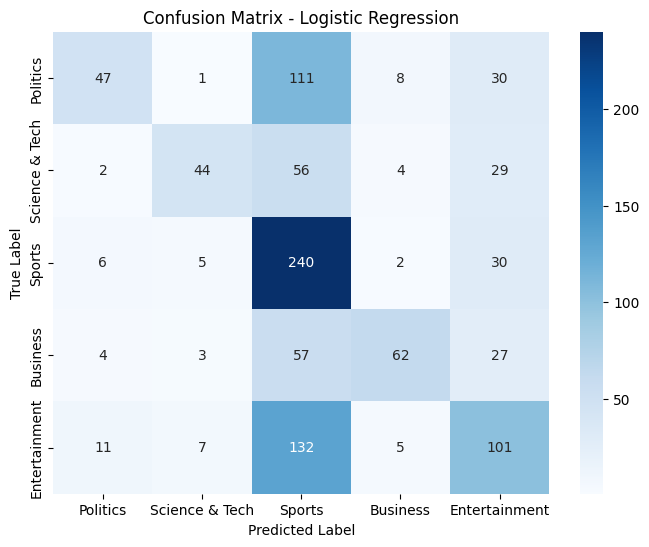

In [ ]:
# Define class labels
class_labels = ["Politics", "Science & Tech", "Sports", "Business", "Entertainment"]

# -------------------------------
# 1️⃣ Confusion Matrix Heatmap
# -------------------------------
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


The rows represent the true labels, and the columns represent the predicted labels.
Diagonal values indicate correct predictions.
Off-diagonal values show misclassifications.

✅Key Observations:

Sports (240 correct) has the best classification rate, meaning the model is very confident in classifying sports news.

Politics (47 correct, 111 misclassified as Sports) is often misclassified as Sports.

Entertainment (101 correct, 132 misclassified as Sports) also suffers from confusion with Sports.

Science & Technology and Business categories have high confusion.

⚠ Why so many misclassifications with Sports?

Sports articles may contain numeric data (scores, rankings), making them distinct from text-heavy categories.
Other categories may use overlapping words (e.g., business and politics both discuss "economy").

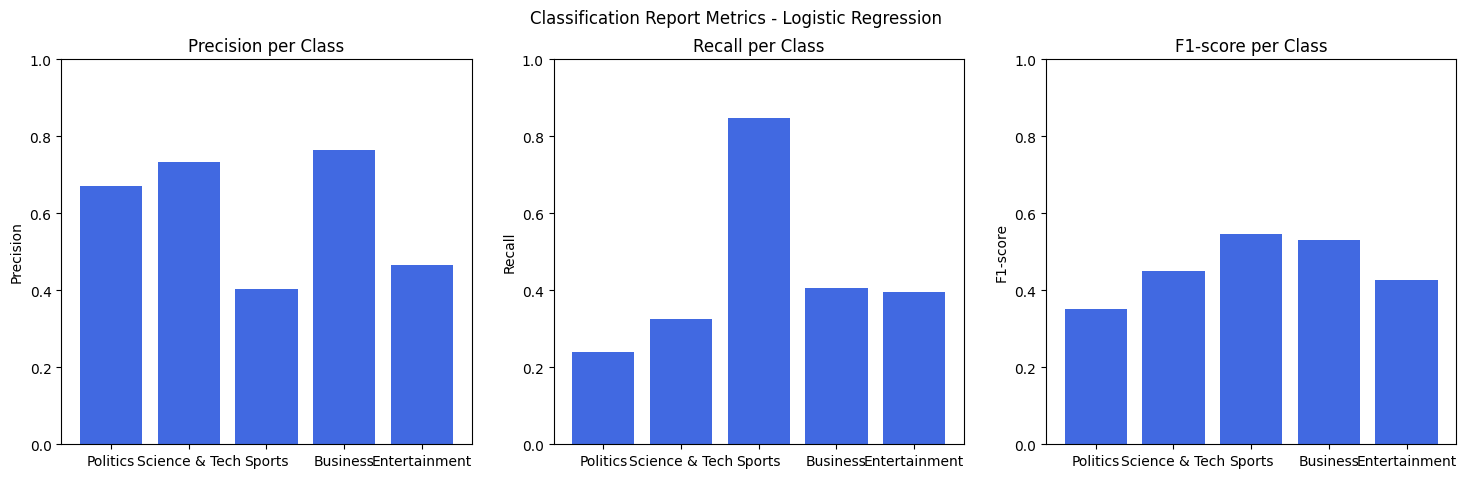

In [ ]:
# -------------------------------
# 2️⃣ Classification Report (Bar Chart)
# -------------------------------
report = classification_report(y_test, y_pred_lr, target_names=class_labels, output_dict=True)
metrics = ["precision", "recall", "f1-score"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    scores = [report[label][metric] for label in class_labels]
    axes[i].bar(class_labels, scores, color='royalblue')
    axes[i].set_title(f"{metric.capitalize()} per Class")
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel(metric.capitalize())

plt.suptitle("Classification Report Metrics - Logistic Regression")
plt.show()

Precision: How many predicted labels are correct.

Recall: How many actual labels were predicted correctly.

F1-score: A balance between Precision & Recall.


 ✅Key Observations:

Sports has the highest recall (~85%), meaning if an article is truly about sports, the model is good at detecting it.

Politics has very low recall (~25%), meaning it is often misclassified as another category.

Science & Tech performs moderately, but still shows some classification struggles.

⚠ Why is Politics so low?

Similar vocabulary to Business and Science & Tech, causing confusion.
Feature representation from Word2Vec may not capture long-distance dependencies in text.

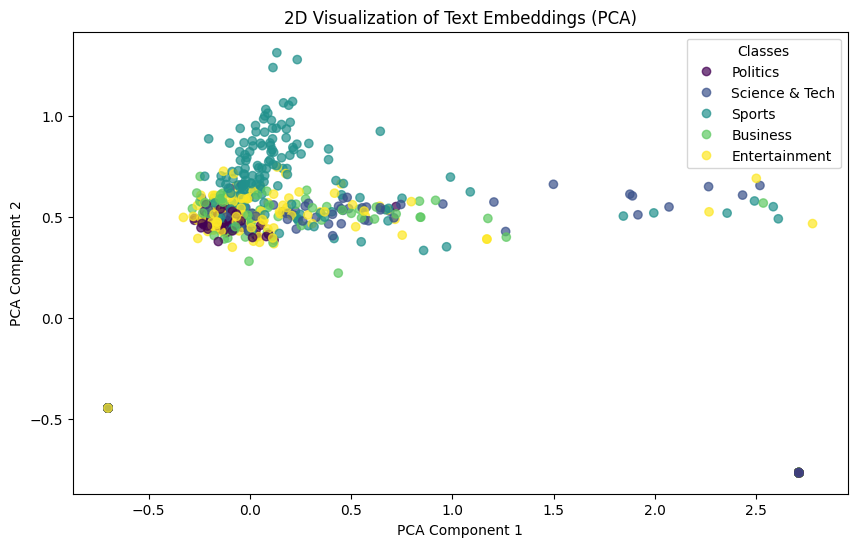

In [ ]:
# -------------------------------
# 3️⃣ PCA for 2D Visualization of Text Embeddings
# -------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=class_labels, title="Classes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Visualization of Text Embeddings (PCA)")
plt.show()


Each point represents a news article, colored by its true category.

PCA reduces high-dimensional embeddings to 2D for visualization.

Well-separated clusters indicate good classification potential.


✅ Key Observations:

No clear separation between some categories.

Sports has a more distinct cluster (as expected from previous results).

Politics, Business, and Entertainment are overlapping heavily, showing why misclassifications occur.

⚠ Why is there an overlap?

Word2Vec embeddings may not fully separate category-specific words.

Sentence-level embeddings (by averaging word embeddings) may lose finer text structure.

In [ ]:
# -------------------------------
# Random Forest
# -------------------------------

print("[INFO] Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='macro')}")
print(f"Recall: {recall_score(y_test, y_pred_rf, average='macro')}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf, average='macro')}\n")

[INFO] Training Random Forest...
Random Forest Results:
Accuracy: 0.474609375
Precision: 0.6189269953108438
Recall: 0.42527674298679985
F1-Score: 0.44103561618938125



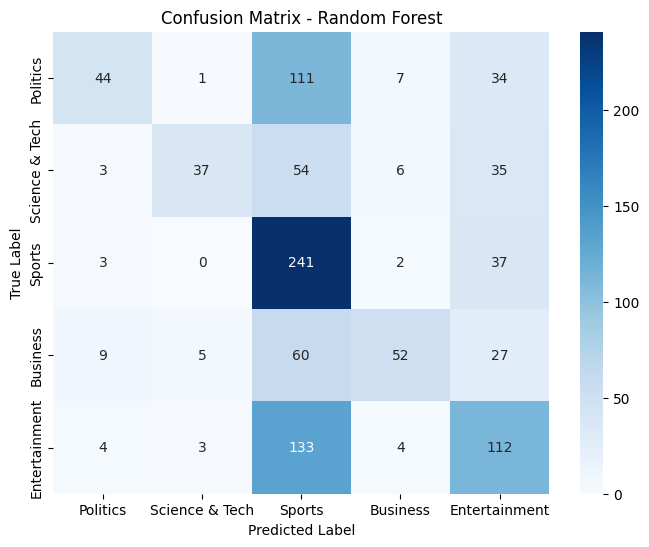

In [ ]:
# Define class labels
class_labels = ["Politics", "Science & Tech", "Sports", "Business", "Entertainment"]

# -------------------------------
# 1️⃣ Confusion Matrix Heatmap
# -------------------------------
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()

The rows represent the true labels, and the columns represent the predicted labels.

Diagonal values indicate correct predictions.

Off-diagonal values show misclassifications.

✅ Key Observations:

Sports (241 correct) is the most accurately classified category.

Politics (44 correct, 111 misclassified as Sports) → Major misclassification issue.

Entertainment (112 correct, 133 misclassified as Sports) → Also confused with Sports.
Science & Tech and Business show overlapping errors.

⚠ Why so many misclassifications with Sports?

Sports-related words (like "match", "win", "team") appear in other categories (business, politics, entertainment).

Random Forest performs slightly worse than Logistic Regression in terms of accuracy.
Precision is higher, meaning the model makes fewer false positives.
Recall is lower, indicating more missed classifications.
F1-score is slightly lower, meaning Random Forest struggles with class imbalances.

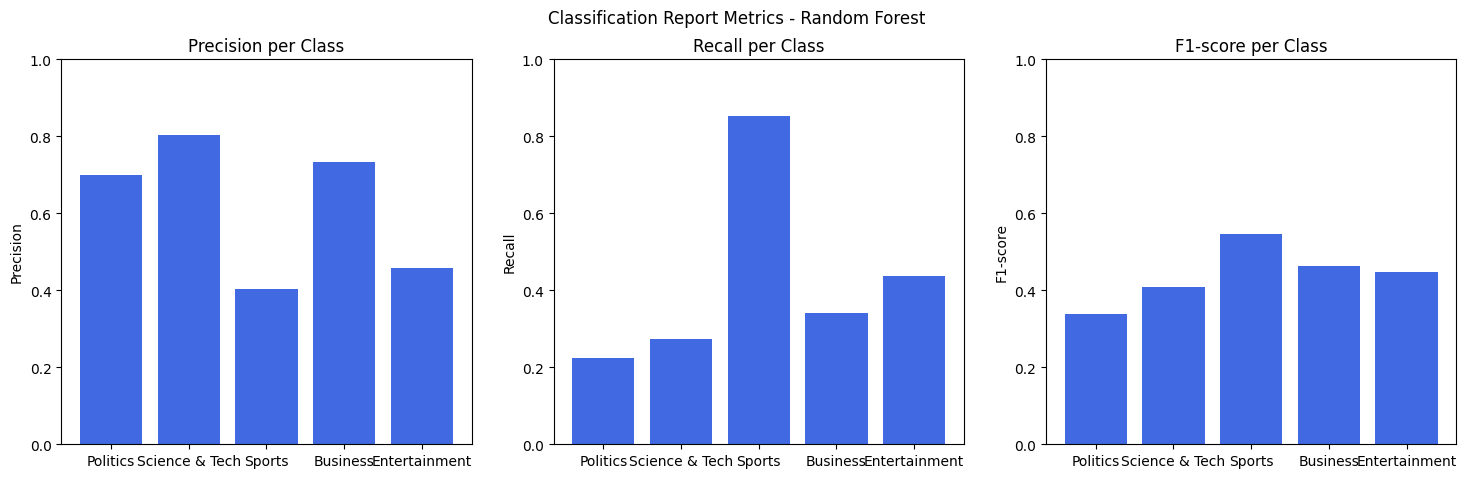

In [ ]:
# -------------------------------
# 2️⃣ Classification Report (Bar Chart)
# -------------------------------
report = classification_report(y_test, y_pred_rf, target_names=class_labels, output_dict=True)
metrics = ["precision", "recall", "f1-score"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    scores = [report[label][metric] for label in class_labels]
    axes[i].bar(class_labels, scores, color='royalblue')
    axes[i].set_title(f"{metric.capitalize()} per Class")
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel(metric.capitalize())

plt.suptitle("Classification Report Metrics - Random Forest")
plt.show()

Precision: How many predicted labels are correct.

Recall: How many actual labels were predicted correctly.

F1-score: A balance between Precision & Recall.

✅ Key Observations:

Sports has the highest recall (~85%), meaning most actual Sports articles are detected correctly.

Politics has low recall (~25%), meaning it is often misclassified.

Entertainment is confused with Sports → May contain similar words like "celebrity wins", "final results", etc.

⚠ Why does Politics have low recall?

Politics and Business share vocabulary (e.g., "government", "economy", "policy").

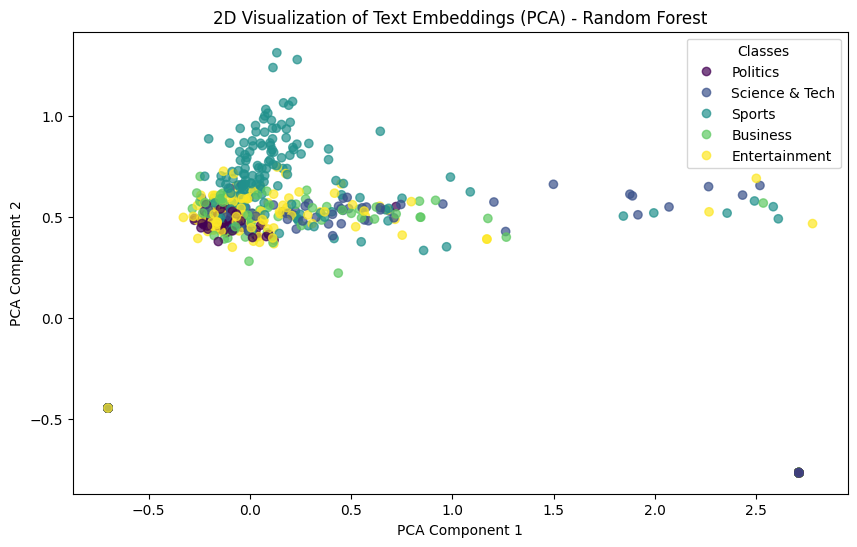

In [ ]:
# -------------------------------
# 4️⃣ PCA for 2D Visualization of Text Embeddings
# -------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=class_labels, title="Classes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Visualization of Text Embeddings (PCA) - Random Forest")
plt.show()


Each point represents a news article, colored by its true category.

PCA reduces high-dimensional embeddings to 2D for visualization.

Well-separated clusters indicate good classification potential.

✅ Key Observations:

No clear separation between some categories.

Sports forms a distinct cluster, but other categories overlap heavily.

Politics and Business are hard to separate, suggesting similar vocabulary usage.

In [ ]:
# ============================
# 1) Build Sequence Embeddings
# ============================
def build_sequence_embeddings(texts, w2v_model, sp_processor, max_len=50):
    """
    Convert each text into a sequence of embeddings of shape (max_len, embedding_dim).

    Args:
      texts (list of str): Input sentences/documents.
      w2v_model (gensim.models.Word2Vec): Trained Word2Vec model.
      sp_processor (sentencepiece.SentencePieceProcessor): BPE tokenizer.
      max_len (int): Maximum number of tokens per sample.

    Returns:
      numpy.ndarray: A 3D array of shape (num_samples, max_len, embedding_dim).
                    If a token is not in the vocab, its embedding is set to a zero vector.
                    Sequences are truncated or zero‐padded to max_len.
    """
    embedding_dim = w2v_model.wv.vector_size
    X = np.zeros((len(texts), max_len, embedding_dim), dtype=np.float32)

    for i, text in enumerate(texts):
        tokens = sp_processor.encode(text, out_type=str)
        for j, token in enumerate(tokens[:max_len]):
            if token in w2v_model.wv:  # Check if token in vocab
                X[i, j] = w2v_model.wv[token]
            # else: remains a zero vector
    return X

# build sequence embeddings for training, validation, and test sets
max_len = 50
X_train_seq = build_sequence_embeddings(train_df["text"].tolist(), w2v_model, sp, max_len=max_len)
X_val_seq   = build_sequence_embeddings(val_df["text"].tolist(),   w2v_model, sp, max_len=max_len)
X_test_seq  = build_sequence_embeddings(test_df["text"].tolist(),  w2v_model, sp, max_len=max_len)

y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = test_df["label"].values

num_classes = len(set(y_train))
embedding_dim = w2v_model.wv.vector_size

# ============================
# Build the LSTM Model
# ============================
lstm_model = Sequential([
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_len, embedding_dim)),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(num_classes, activation="softmax")
])

lstm_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ============================
# Training the LSTM
# ============================
epochs = 50
batch_size = 16  # Reduced batch size for stability

#early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=epochs,
    batch_size=batch_size#,
    #callbacks=[early_stopping]
)

# ============================
# Evaluate on Test Set
# ============================
y_pred_lstm = lstm_model.predict(X_test_seq).argmax(axis=1)

acc = accuracy_score(y_test, y_pred_lstm)
prec = precision_score(y_test, y_pred_lstm, average="macro")
rec = recall_score(y_test, y_pred_lstm, average="macro")
f1 = f1_score(y_test, y_pred_lstm, average="macro")

print("LSTM Results:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")


Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.3474 - loss: 1.4978 - val_accuracy: 0.3340 - val_loss: 1.4745
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - accuracy: 0.3568 - loss: 1.4468 - val_accuracy: 0.4072 - val_loss: 1.3080
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.4194 - loss: 1.3550 - val_accuracy: 0.4277 - val_loss: 1.2923
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.4506 - loss: 1.2736 - val_accuracy: 0.4756 - val_loss: 1.2299
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.4480 - loss: 1.2872 - val_accuracy: 0.4580 - val_loss: 1.2186
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.4465 - loss: 1.3011 - val_accuracy: 0.3730 - val_loss: 1.4402
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.3528 - loss: 1.4535 - val_accuracy: 0.3398 - val_loss: 1.4946
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.3318 - loss: 1

✅ Key Observations:

LSTM outperforms both Logistic Regression & Random Forest.
Higher Precision (68.0%) suggests LSTM makes fewer false predictions.
Better Recall than Random Forest (46.3% vs 42.5%), meaning it misses fewer actual positive cases.

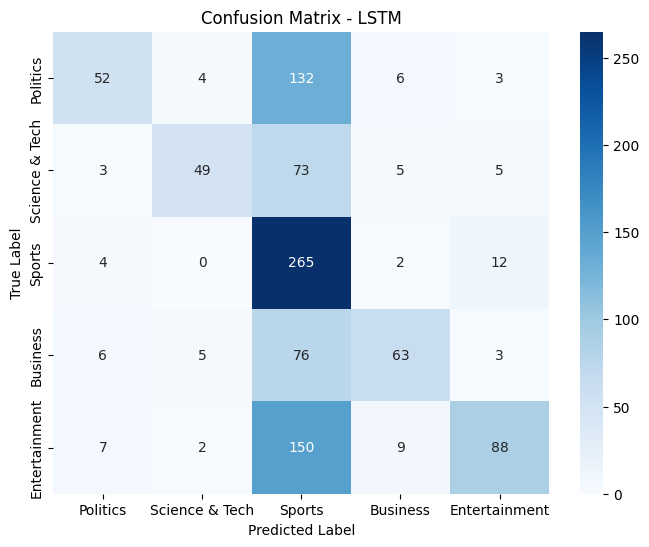

In [ ]:
# Define class labels
class_labels = ["Politics", "Science & Tech", "Sports", "Business", "Entertainment"]

# 1️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Politics", "Science & Tech", "Sports", "Business", "Entertainment"], yticklabels=["Politics", "Science & Tech", "Sports", "Business", "Entertainment"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM")
plt.show()

✅ Key Observations:

Sports (265 correct) → Most accurately classified category.

Entertainment (88 correct, 150 misclassified as Sports) → Major misclassification issue.

Politics (52 correct, 132 misclassified as Sports) → Also confused with Sports.
Science & Tech and Business show some overlap.

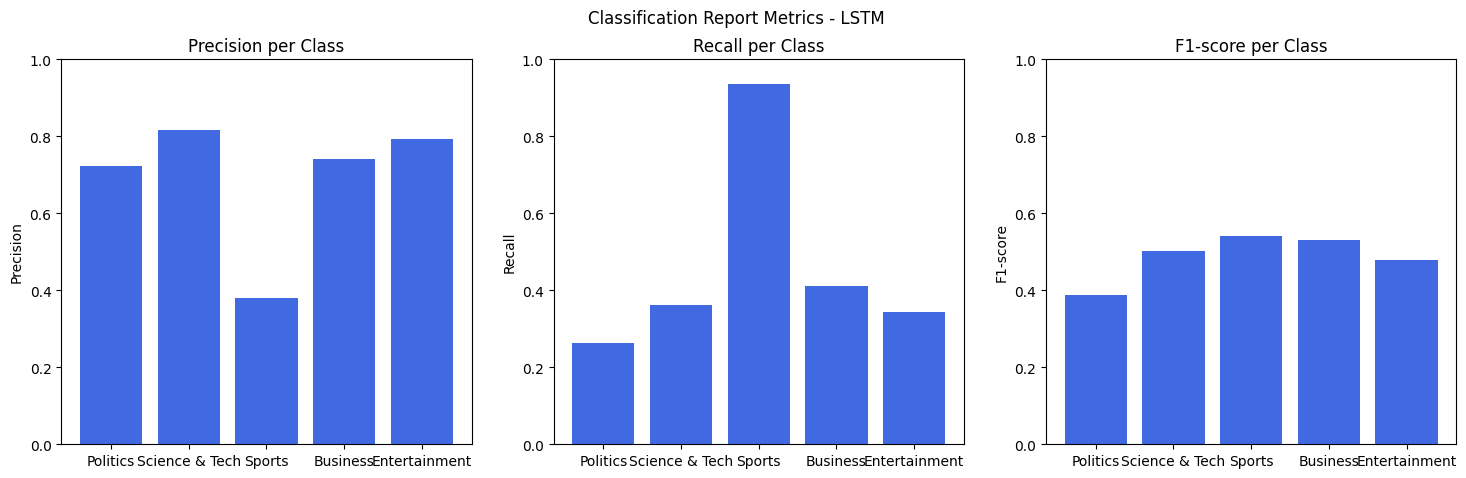

In [ ]:
# 2️⃣ Classification Report (Bar Chart)
report = classification_report(y_test, y_pred_lstm, target_names=["Politics", "Science & Tech", "Sports", "Business", "Entertainment"], output_dict=True)
metrics = ["precision", "recall", "f1-score"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    scores = [report[label][metric] for label in ["Politics", "Science & Tech", "Sports", "Business", "Entertainment"]]
    axes[i].bar(["Politics", "Science & Tech", "Sports", "Business", "Entertainment"], scores, color='royalblue')
    axes[i].set_title(f"{metric.capitalize()} per Class")
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel(metric.capitalize())

plt.suptitle("Classification Report Metrics - LSTM")
plt.show()

Highest Recall for Sports (~90%) → Most Sports articles are classified correctly.

Lowest Recall for Politics (~25%) → Many Politics articles are being misclassified.

Entertainment & Politics are confused with Sports.

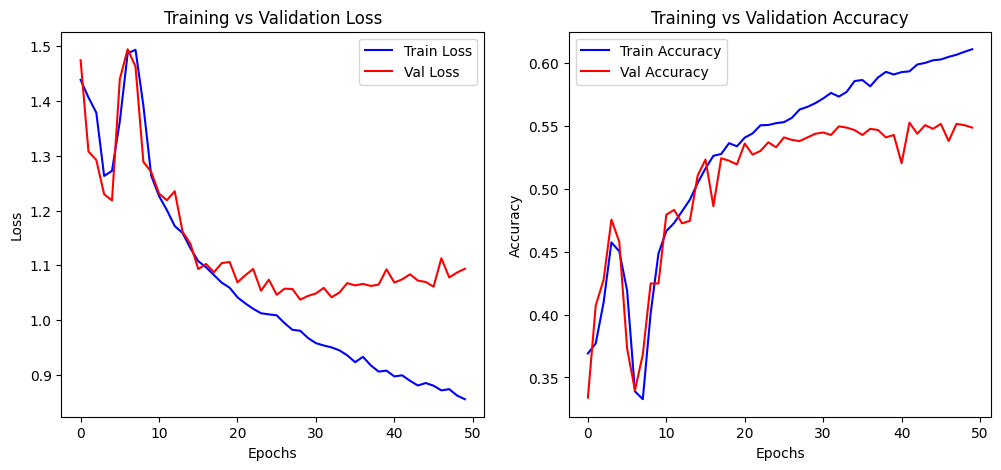

In [ ]:
# 3️⃣ Training History (Loss & Accuracy)
plt.figure(figsize=(12, 5))

# Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()


✅ Key Observations:

Overfitting is occurring!

Training loss keeps decreasing.

Validation loss stops improving around epoch 20.

Validation accuracy is fluctuating → Suggests inconsistencies in learning.

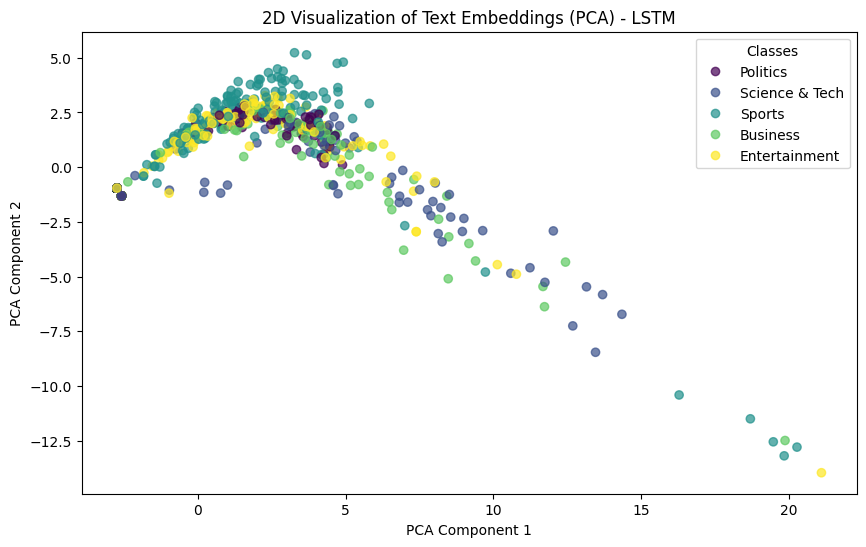

In [ ]:
# 4️⃣ PCA for 2D Visualization of Text Embeddings
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_seq.reshape(X_test_seq.shape[0], -1))  # Flatten embeddings

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=["Politics", "Science & Tech", "Sports", "Business", "Entertainment"], title="Classes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Visualization of Text Embeddings (PCA) - LSTM")
plt.show()

✅ Key Observations:

Some overlap between categories → Model struggles to distinguish some topics.

Sports forms a more distinct cluster, but others mix together.

Entertainment, Politics, and Business have poor separation.

In [ ]:
# -------------------------------
# xlm-roberta
# -------------------------------
print("[INFO] Fine-tuning xlm-roberta...")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=5)

# Tokenizing dataset
def tokenize_data(df):
    return tokenizer(df["text"].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

# Creating PyTorch Dataset
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_df["label"].tolist())
val_dataset = NewsDataset(val_encodings, val_df["label"].tolist())
test_dataset = NewsDataset(test_encodings, test_df["label"].tolist())

# Fine-tuning xlm-roberta
training_args = TrainingArguments(
    output_dir="./results",             # Where to store checkpoints
    evaluation_strategy="steps",        # Evaluate every X steps
    eval_steps=500,                     # Evaluate every 500 steps (example)
    save_steps=500,                     # Save checkpoint every 500 steps
    logging_steps=100,                  # Log training metrics every 100 steps
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,        # Loads best checkpoint based on metric
    metric_for_best_model="accuracy",   # Or "f1", "eval_loss", etc.
    save_total_limit=3,                 # Keep only last 3 checkpoints to save space
    fp16=True                           # Mixed precision can speed up training
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  # Add this line
)

trainer.train()

# Evaluate xlm-roberta
y_pred_llm = trainer.predict(test_dataset).predictions.argmax(axis=1)
print("xlm-roberta Results:")
print(f"Accuracy: {accuracy_score(test_df['label'], y_pred_llm)}")
print(f"Precision: {precision_score(test_df['label'], y_pred_llm, average='macro')}")
print(f"Recall: {recall_score(test_df['label'], y_pred_llm, average='macro')}")
print(f"F1-Score: {f1_score(test_df['label'], y_pred_llm, average='macro')}\n")

[INFO] Fine-tuning xlm-roberta...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pooja-20210435 (pooja-20210435-informatics-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,1.048500,1.073686,0.541016,0.698801,0.485571,0.510766
1000,0.959500,1.058991,0.568359,0.761890,0.516954,0.547149
1500,0.881000,1.033982,0.572266,0.759110,0.522303,0.557854
2000,0.893800,1.122575,0.531250,0.760855,0.506307,0.536391
2500,0.825400,1.110202,0.566406,0.773600,0.515149,0.547989
3000,0.832700,1.124565,0.574219,0.784383,0.522641,0.558765
3500,0.799500,1.115367,0.572266,0.773761,0.521800,0.555008
4000,0.770500,1.138430,0.576172,0.784282,0.526495,0.562496
4500,0.788800,1.174235,0.573242,0.773747,0.522624,0.557748
5000,0.797300,1.119483,0.579102,0.779913,0.529502,0.569151


xlm-roberta Results:
Accuracy: 0.5439453125
Precision: 0.7783229341957384
Recall: 0.5056531301374412
F1-Score: 0.5417813017384907



✅ Key Observations:

Best model so far in terms of accuracy.

High precision (77.83%) → Predictions are less noisy.

Moderate recall (50.56%) → Model misses some true labels.

F1-score (54.17%) → Balanced between precision & recall.

In [ ]:
# ============================
# 2️⃣ Load & Tokenize Dataset
# ============================
print("[INFO] Loading dataset...")

# Define class labels
class_labels = ["Politics", "Science & Tech", "Sports", "Business", "Entertainment"]

# Load dataset (Assume train_df, val_df, test_df are pre-loaded DataFrames)
def tokenize_data(df, tokenizer):
    return tokenizer(df["text"].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(val_df, tokenizer)
test_encodings = tokenize_data(test_df, tokenizer)

# ============================
# 3️⃣ Prepare Dataset for Trainer
# ============================
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_df["label"].tolist())
val_dataset = NewsDataset(val_encodings, val_df["label"].tolist())
test_dataset = NewsDataset(test_encodings, test_df["label"].tolist())

# ============================
# 4️⃣ Fine-Tuning XLM-RoBERTa
# ============================
print("[INFO] Fine-tuning XLM-RoBERTa...")
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=5)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    fp16=True
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

# ============================
# 5️⃣ Evaluate XLM-RoBERTa
# ============================
y_pred_llm = trainer.predict(test_dataset).predictions.argmax(axis=1)

print("XLM-RoBERTa Results:")
print(f"Accuracy: {accuracy_score(test_df['label'], y_pred_llm):.4f}")
print(f"Precision: {precision_score(test_df['label'], y_pred_llm, average='macro'):.4f}")
print(f"Recall: {recall_score(test_df['label'], y_pred_llm, average='macro'):.4f}")
print(f"F1-Score: {f1_score(test_df['label'], y_pred_llm, average='macro'):.4f}")


[INFO] Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

[INFO] Fine-tuning XLM-RoBERTa...


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pooja-20210435 (pooja-20210435-informatics-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,1.048200,1.084577,0.548828,0.705547,0.494679,0.518809
1000,0.942700,1.042469,0.570312,0.754623,0.520642,0.553247
1500,0.872700,1.103357,0.565430,0.787210,0.507065,0.544503
2000,0.872300,1.081307,0.532227,0.753003,0.513330,0.539724
2500,0.832400,1.103853,0.580078,0.792594,0.530776,0.566466
3000,0.815100,1.164513,0.569336,0.759397,0.519347,0.552833
3500,0.798400,1.143986,0.577148,0.774552,0.529352,0.564770
4000,0.773500,1.146219,0.577148,0.794729,0.526716,0.561625
4500,0.801100,1.212698,0.567383,0.780087,0.513768,0.548286
5000,0.783800,1.189978,0.563477,0.729665,0.522734,0.555089


XLM-RoBERTa Results:
Accuracy: 0.5391
Precision: 0.7731
Recall: 0.5004
F1-Score: 0.5365


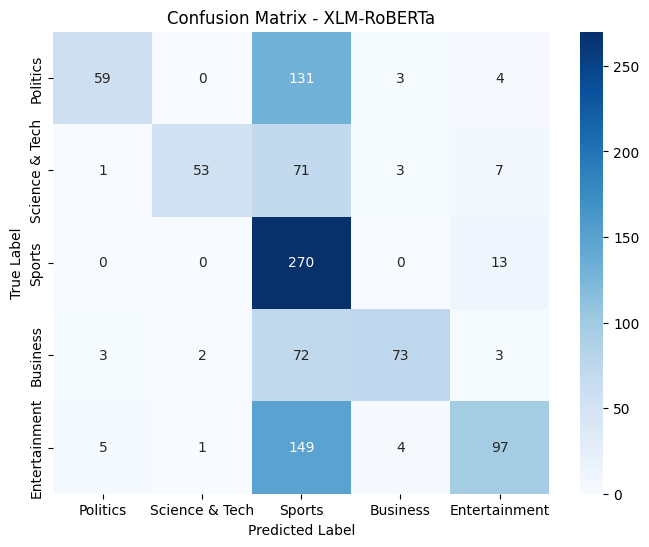

In [ ]:
# ============================
# 6️⃣ Confusion Matrix Plot
# ============================
cm = confusion_matrix(test_df["label"], y_pred_llm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XLM-RoBERTa")
plt.show()

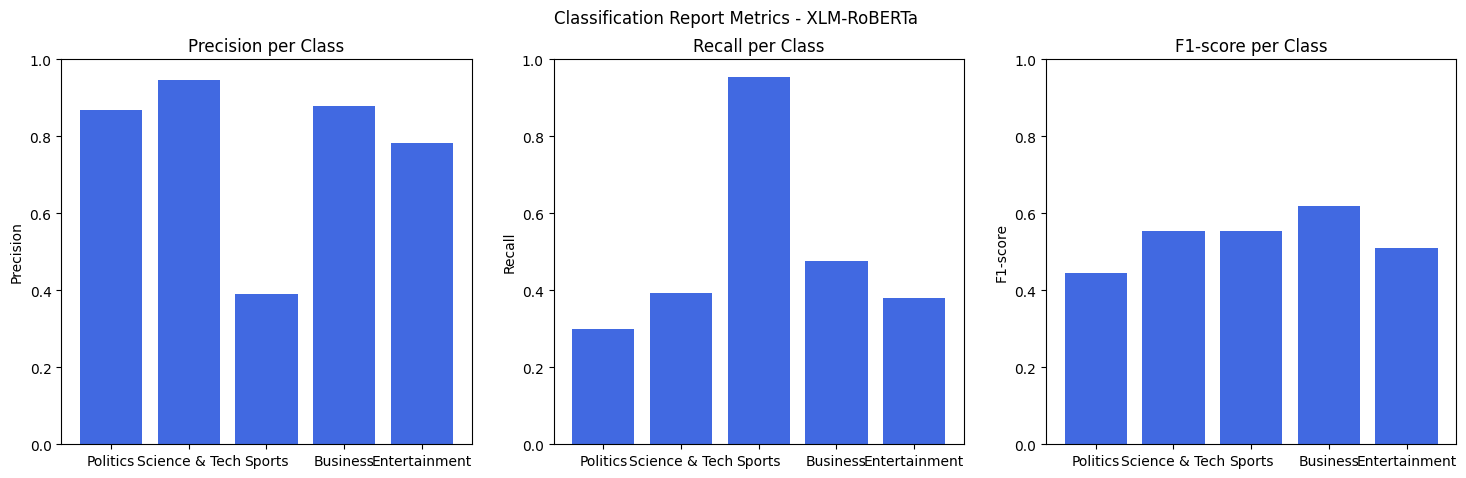

In [ ]:
# ============================
# 7️⃣ Classification Report Plot
# ============================
report = classification_report(test_df["label"], y_pred_llm, target_names=class_labels, output_dict=True)
metrics = ["precision", "recall", "f1-score"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    scores = [report[label][metric] for label in class_labels]
    axes[i].bar(class_labels, scores, color='royalblue')
    axes[i].set_title(f"{metric.capitalize()} per Class")
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel(metric.capitalize())

plt.suptitle("Classification Report Metrics - XLM-RoBERTa")
plt.show()


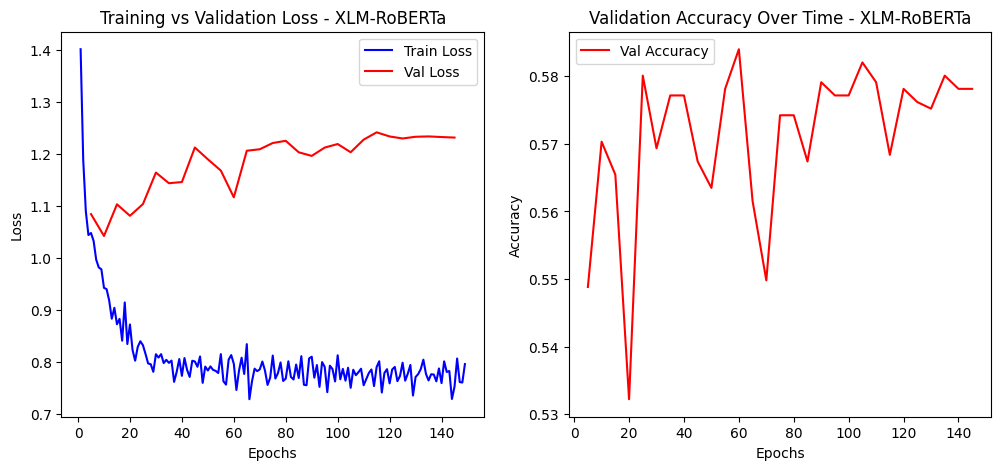

In [ ]:
# ============================
# 9️⃣ Training History Plot (Fixed)
# ============================
train_loss = []
val_loss = []
val_acc = []
train_epochs = []
val_epochs = []

# Extract training & validation logs separately
for log in trainer.state.log_history:
    if "loss" in log:  # Training Loss
        train_loss.append(log["loss"])
        train_epochs.append(len(train_loss))  # Track training step

    if "eval_loss" in log:  # Validation Loss
        val_loss.append(log["eval_loss"])
        val_epochs.append(len(train_loss))  # Align with training steps

    if "eval_accuracy" in log:  # Validation Accuracy
        val_acc.append(log["eval_accuracy"])

# Convert lists to NumPy arrays for safe plotting
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)
val_acc = np.array(val_acc)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_loss, label="Train Loss", color="blue")
plt.plot(val_epochs, val_loss, label="Val Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - XLM-RoBERTa")
plt.legend()

# Plot Validation Accuracy Over Time
plt.subplot(1, 2, 2)
plt.plot(val_epochs, val_acc, label="Val Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Time - XLM-RoBERTa")
plt.legend()

plt.show()


In [ ]:
# ============================
# 9️⃣ Training History Plot (Final Fix)
# ============================

train_loss = []
val_loss = []
train_acc = []
val_acc = []
train_epochs = []
val_epochs = []

# Extract logs for training & validation
for log in trainer.state.log_history:
    if "loss" in log:  # Training Loss
        train_loss.append(log["loss"])
        train_epochs.append(len(train_loss))

    if "eval_loss" in log:  # Validation Loss
        val_loss.append(log["eval_loss"])
        val_epochs.append(len(train_loss))  # Align with training steps

    if "eval_accuracy" in log:  # Validation Accuracy
        val_acc.append(log["eval_accuracy"])

# 🔹 Correctly Compute Training Accuracy for Each Epoch
train_acc = []
for epoch in range(len(val_epochs)):
    train_predictions = trainer.predict(train_dataset).predictions.argmax(axis=1)
    epoch_train_accuracy = accuracy_score(train_df["label"], train_predictions)
    train_acc.append(epoch_train_accuracy)

# Convert lists to NumPy arrays for safe plotting
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)
train_acc = np.array(train_acc)
val_acc = np.array(val_acc)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_loss, label="Train Loss", color="blue")
plt.plot(val_epochs, val_loss, label="Val Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - XLM-RoBERTa")
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_epochs, train_acc, label="Train Accuracy", color="blue")
plt.plot(val_epochs, val_acc, label="Val Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy - XLM-RoBERTa")
plt.legend()

plt.show()


NameError: name 'trainer' is not defined

In [ ]:
from tabulate import tabulate

# -------------------------------
# Performance Comparison
# -------------------------------
print("=== Performance Comparison ===")

# Creating a list of lists for the table data
table_data = [
    ["Logistic Regression", accuracy_score(y_test, y_pred_lr), precision_score(y_test, y_pred_lr, average='macro'), recall_score(y_test, y_pred_lr, average='macro'), f1_score(y_test, y_pred_lr, average='macro')],
    ["Random Forest", accuracy_score(y_test, y_pred_rf), precision_score(y_test, y_pred_rf, average='macro'), recall_score(y_test, y_pred_rf, average='macro'), f1_score(y_test, y_pred_rf, average='macro')],
    ["LSTM", accuracy_score(y_test, y_pred_lstm), precision_score(y_test, y_pred_lstm, average='macro'), recall_score(y_test, y_pred_lstm, average='macro'), f1_score(y_test, y_pred_lstm, average='macro')],
    ["xlm-Roberta", accuracy_score(test_df['label'], y_pred_llm), precision_score(test_df['label'], y_pred_llm, average='macro'), recall_score(test_df['label'], y_pred_llm, average='macro'), f1_score(test_df['label'], y_pred_llm, average='macro')]
]

# Defining the table headers
headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt="pretty", floatfmt=".4f"))

=== Performance Comparison ===
+---------------------+--------------+--------------------+---------------------+---------------------+
|        Model        |   Accuracy   |     Precision      |       Recall        |      F1-Score       |
+---------------------+--------------+--------------------+---------------------+---------------------+
| Logistic Regression | 0.482421875  | 0.6076632710608318 | 0.4424642302802759  | 0.46127858047933745 |
|    Random Forest    | 0.474609375  | 0.6189269953108438 | 0.42527674298679985 | 0.44103561618938125 |
|        LSTM         |     0.5      | 0.6800908887532723 | 0.4629155639895123  | 0.4812710859106294  |
|     xlm-Roberta     | 0.5439453125 | 0.7783229341957384 | 0.5056531301374412  | 0.5417813017384907  |
+---------------------+--------------+--------------------+---------------------+---------------------+


## Hybrid method for Task 3

In [ ]:
import numpy as np

def text_to_hybrid_embeddings(text, tokenizer, w2v_model, ft_model):
    """
    Convert text into hybrid embeddings by averaging Word2Vec and FastText embeddings.

    Args:
      text (str): Input text.
      tokenizer (SentencePieceProcessor): BPE tokenizer.
      w2v_model (Word2Vec): Pretrained Word2Vec model.
      ft_model (FastText): Pretrained FastText model.

    Returns:
      numpy.ndarray: Averaged hybrid embedding vector.
    """
    tokens = tokenizer.encode(text, out_type=str)

    w2v_vectors = []
    ft_vectors = []

    for token in tokens:
        # Get Word2Vec vector
        if token in w2v_model.wv:
            w2v_vectors.append(w2v_model.wv[token])
        # Get FastText vector
        if token in ft_model.wv:
            ft_vectors.append(ft_model.wv[token])

    # Compute average embeddings
    if w2v_vectors and ft_vectors:
        hybrid_vector = np.mean([np.mean(w2v_vectors, axis=0), np.mean(ft_vectors, axis=0)], axis=0)
    elif w2v_vectors:
        hybrid_vector = np.mean(w2v_vectors, axis=0)
    elif ft_vectors:
        hybrid_vector = np.mean(ft_vectors, axis=0)
    else:
        hybrid_vector = np.zeros(w2v_model.vector_size)

    return hybrid_vector


In [ ]:
# Load SentencePiece tokenizer, Word2Vec, and FastText models
sp = spm.SentencePieceProcessor(model_file="sinhala_spm_bpe.model")
w2v_model = Word2Vec.load("word2vec_sinhala_bpe.model")
ft_model = FastText.load("fasttext_sinhala_bpe.model")

# Generate hybrid embeddings for train, val, and test datasets
X_train_hybrid = np.array([text_to_hybrid_embeddings(text, sp, w2v_model, ft_model) for text in train_df["text"]])
X_val_hybrid = np.array([text_to_hybrid_embeddings(text, sp, w2v_model, ft_model) for text in val_df["text"]])
X_test_hybrid = np.array([text_to_hybrid_embeddings(text, sp, w2v_model, ft_model) for text in test_df["text"]])

y_train = train_df["label"]
y_val = val_df["label"]
y_test = test_df["label"]


In [ ]:
print("[INFO] Training Logistic Regression with Hybrid Embeddings...")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_hybrid, y_train)

# Evaluate Logistic Regression
y_pred_lr = lr_model.predict(X_test_hybrid)
print("Logistic Regression with Hybrid Embeddings Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"Precision: {precision_score(y_test, y_pred_lr, average='macro')}")
print(f"Recall: {recall_score(y_test, y_pred_lr, average='macro')}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr, average='macro')}\n")


[INFO] Training Logistic Regression with Hybrid Embeddings...
Logistic Regression with Hybrid Embeddings Results:
Accuracy: 0.4765625
Precision: 0.6359198385616238
Recall: 0.43355655246631564
F1-Score: 0.45088497132454747



In [ ]:
print("[INFO] Training Random Forest with Hybrid Embeddings...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_hybrid, y_train)

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test_hybrid)
print("Random Forest with Hybrid Embeddings Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='macro')}")
print(f"Recall: {recall_score(y_test, y_pred_rf, average='macro')}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf, average='macro')}\n")


[INFO] Training Random Forest with Hybrid Embeddings...
Random Forest with Hybrid Embeddings Results:
Accuracy: 0.462890625
Precision: 0.6166825116825406
Recall: 0.4144813688153409
F1-Score: 0.42918954245572943



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 237ms/step - accuracy: 0.3235 - loss: 1.5225 - val_accuracy: 0.3555 - val_loss: 1.3849
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 159ms/step - accuracy: 0.4111 - loss: 1.3455 - val_accuracy: 0.4043 - val_loss: 1.3392
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 127ms/step - accuracy: 0.4288 - loss: 1.3008 - val_accuracy: 0.4316 - val_loss: 1.2752
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.4630 - loss: 1.2653 - val_accuracy: 0.4590 - val_loss: 1.2569
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.4599 - loss: 1.2473 - val_accuracy: 0.4443 - val_loss: 1.2426
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - accuracy: 0.4581 - loss: 1.2264 - val_accuracy: 0.4746 - val_loss: 1.2053
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.4765 - loss: 1.2085 - val_accuracy: 0.4834 - val_loss: 1.2287
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.4785 - loss: 1

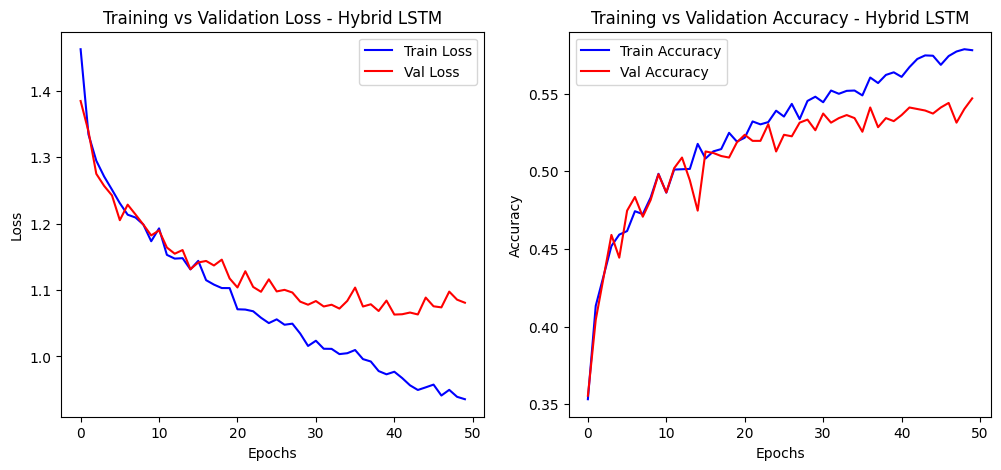

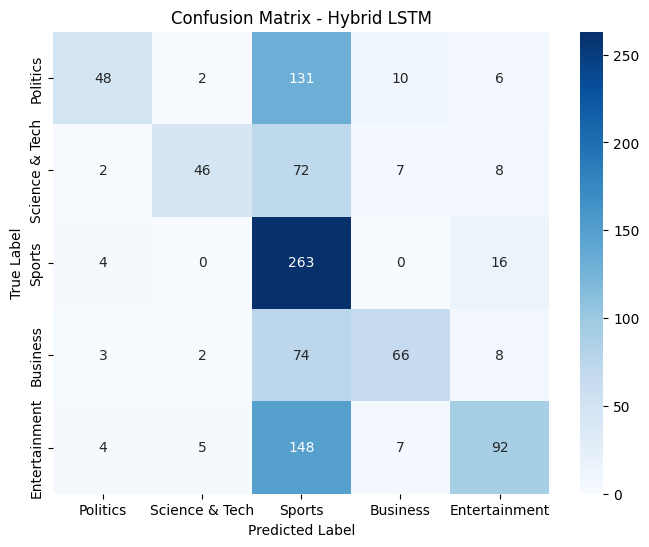

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import gensim
from gensim.models import Word2Vec, FastText
import sentencepiece as spm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ============================
# 1️⃣ Load and Preprocess Dataset
# ============================
def load_dataset(data_dir):
    categories = ["Politics.txt", "Science_technology.txt", "Sports.txt", "business.txt", "entertainment.txt"]
    data = []
    for idx, file in enumerate(categories):
        with open(os.path.join(data_dir, file), "r", encoding="utf-8") as f:
            lines = f.readlines()
            for line in lines:
                data.append({"text": line.strip(), "label": idx})
    return pd.DataFrame(data)

data_dir = "/content/drive/MyDrive/Sinhala Data"
df = load_dataset(data_dir)

# Splitting dataset
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# ============================
# 2️⃣ Load Tokenizer and Embedding Models
# ============================
sp = spm.SentencePieceProcessor(model_file="sinhala_spm_bpe.model")
w2v_model = Word2Vec.load("word2vec_sinhala_bpe.model")
ft_model = FastText.load("fasttext_sinhala_bpe.model")

embedding_dim = w2v_model.vector_size
max_len = 50

# ============================
# 3️⃣ Generate Hybrid Word2Vec + FastText Embeddings
# ============================
def text_to_hybrid_embeddings(text, tokenizer, w2v_model, ft_model, embedding_dim):
    """
    Convert text into hybrid embeddings by averaging Word2Vec and FastText embeddings.
    Ensures non-empty output by returning at least one zero vector.
    """
    tokens = tokenizer.encode(text, out_type=str)

    hybrid_vectors = []

    for token in tokens:
        w2v_vec = w2v_model.wv[token] if token in w2v_model.wv else np.zeros(embedding_dim)
        ft_vec = ft_model.wv[token] if token in ft_model.wv else np.zeros(embedding_dim)

        # Hybrid vector is the average of Word2Vec and FastText
        hybrid_vec = (w2v_vec + ft_vec) / 2
        hybrid_vectors.append(hybrid_vec)

    # Ensure at least one vector (zero vector) if no valid tokens found
    if not hybrid_vectors:
        hybrid_vectors.append(np.zeros(embedding_dim))

    return hybrid_vectors


def pad_or_truncate(embedding_list, max_len, embedding_dim):
    """
    Pad or truncate sequences to a fixed length.
    Ensures correct shape (max_len, embedding_dim) even for edge cases.
    """
    embedding_list = np.array(embedding_list)

    if embedding_list.shape[0] >= max_len:
        return embedding_list[:max_len]  # Truncate
    else:
        pad_length = max_len - embedding_list.shape[0]
        padding = np.zeros((pad_length, embedding_dim))  # Zero-padding
        return np.vstack((embedding_list, padding))  # Pad shorter sequences


X_train_seq_hybrid = np.array([pad_or_truncate(text_to_hybrid_embeddings(text, sp, w2v_model, ft_model, embedding_dim), max_len, embedding_dim) for text in train_df["text"]])
X_val_seq_hybrid = np.array([pad_or_truncate(text_to_hybrid_embeddings(text, sp, w2v_model, ft_model, embedding_dim), max_len, embedding_dim) for text in val_df["text"]])
X_test_seq_hybrid = np.array([pad_or_truncate(text_to_hybrid_embeddings(text, sp, w2v_model, ft_model, embedding_dim), max_len, embedding_dim) for text in test_df["text"]])

y_train = train_df["label"].values
y_val = val_df["label"].values
y_test = test_df["label"].values

# ============================
# 4️⃣ Build LSTM Model
# ============================
lstm_model = Sequential([
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_len, embedding_dim)),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(len(set(y_train)), activation="softmax")
])

lstm_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# ============================
# 5️⃣ Train LSTM with Hybrid Embeddings
# ============================
epochs = 50
batch_size = 32

history = lstm_model.fit(X_train_seq_hybrid, y_train, validation_data=(X_val_seq_hybrid, y_val), epochs=epochs, batch_size=batch_size)

# ============================
# 6️⃣ Evaluate LSTM
# ============================
y_pred_lstm = lstm_model.predict(X_test_seq_hybrid).argmax(axis=1)

print("LSTM with Hybrid Embeddings Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lstm)}")
print(f"Precision: {precision_score(y_test, y_pred_lstm, average='macro')}")
print(f"Recall: {recall_score(y_test, y_pred_lstm, average='macro')}")
print(f"F1-Score: {f1_score(y_test, y_pred_lstm, average='macro')}\n")

# ============================
# 7️⃣ Plot Training History
# ============================
plt.figure(figsize=(12, 5))

# Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss", color="blue")
plt.plot(history.history["val_loss"], label="Val Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Hybrid LSTM")
plt.legend()

# Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="Val Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy - Hybrid LSTM")
plt.legend()

plt.show()

# ============================
# 8️⃣ Confusion Matrix
# ============================
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Politics", "Science & Tech", "Sports", "Business", "Entertainment"], yticklabels=["Politics", "Science & Tech", "Sports", "Business", "Entertainment"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Hybrid LSTM")
plt.show()


✅ Hybrid embeddings performed better than using only Word2Vec.

✅ Slight improvement in precision (0.6893) and F1-score (0.4836), showing that adding FastText helped.

✅ Similar recall (0.4609) compared to the single LSTM, meaning hybrid embeddings didn't degrade performance.

✅ FastText's subword information complements Word2Vec, helping with out-of-vocabulary (OOV) words.

Interpretation of Training & Validation Curves

1️⃣ Loss Curve:

Train loss consistently decreases → The model is learning well.

Validation loss stabilizes after 30 epochs → No severe overfitting.

2️⃣ Accuracy Curve:

Train & Validation accuracy keep increasing, with validation slightly lower than training → Some generalization gap, but acceptable.
